In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time
import pandas as pd

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
data_dir = 'C:/Users/ardo/Documents/semai/dataset/ripeness/ripeness_v8.0'
print(data_dir)

C:/Users/ardo/Documents/semai/dataset/ripeness/ripeness_v8.0


In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

Found 474 images belonging to 4 classes.
Found 117 images belonging to 4 classes.


((32, 224, 224, 3), (32, 4))

In [10]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels_ripe.txt', 'w') as f:
  f.write(labels)

{'belum matang': 0, 'jankos': 1, 'lewat matang': 2, 'matang': 3}


In [8]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMAGE_SIZE, 
                                                              IMAGE_SIZE,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [9]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    alpha=1.4,
    #include_top=False, 
    weights='imagenet'
)

In [10]:
base_model.trainable = False

model = tf.keras.Sequential([
  data_augmentation,
  #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  base_model,
  tf.keras.layers.Dropout(0.7),
  #tf.keras.layers.Conv2D(32, 3, activation='relu'),
  #tf.keras.layers.Dropout(0.3),
  #tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.003), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.40_224 (Functi (None, 1000)              6156712   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [11]:
epochs = 1000

early_stop_cuy = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=200, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator), 
    epochs=epochs, 
    validation_data=val_generator, 
    validation_steps=len(val_generator),
    callbacks=[early_stop_cuy]
)

Epoch 1/1000
15/15 [==============================] - 3s 193ms/step - loss: 1.3215 - accuracy: 0.3924 - val_loss: 1.2264 - val_accuracy: 0.4359
Epoch 2/1000
15/15 [==============================] - 1s 95ms/step - loss: 1.2084 - accuracy: 0.4114 - val_loss: 1.1624 - val_accuracy: 0.4359
Epoch 3/1000
15/15 [==============================] - 1s 95ms/step - loss: 1.1751 - accuracy: 0.4768 - val_loss: 1.1254 - val_accuracy: 0.4359
Epoch 4/1000
15/15 [==============================] - 1s 95ms/step - loss: 1.1433 - accuracy: 0.4705 - val_loss: 1.0741 - val_accuracy: 0.6325
Epoch 5/1000
15/15 [==============================] - 1s 96ms/step - loss: 1.1231 - accuracy: 0.4958 - val_loss: 1.0061 - val_accuracy: 0.6581
Epoch 6/1000
15/15 [==============================] - 1s 96ms/step - loss: 1.0813 - accuracy: 0.5527 - val_loss: 0.9385 - val_accuracy: 0.7009
Epoch 7/1000
15/15 [==============================] - 1s 96ms/step - loss: 1.0462 - accuracy: 0.5612 - val_loss: 0.8671 - val_accuracy: 0.726

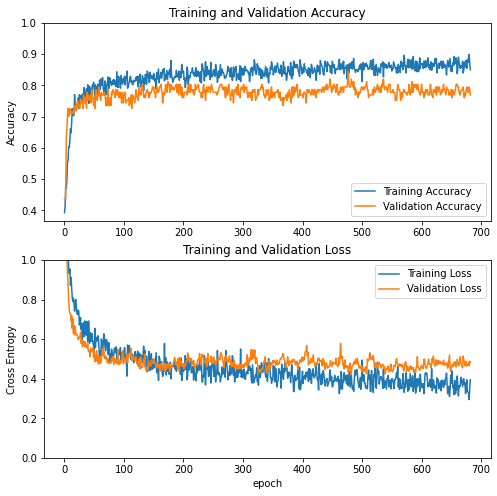

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
saved_model_dir = 'save/trans_learn'
tf.saved_model.save(model, saved_model_dir)

In [28]:
timename = time.strftime("%Y%m%d%H%M%S")
saved_model_path = "ripeness-" + timename + ".h5" # or you can simply use 'my_model.h5'
model.save(saved_model_path) #save your model

In [2]:
# to reload your model if no snippet keras layer e.g MobileNetV2
other_model_h5_path = 'C:/Users/ardo/Documents/personal/dev/notebook/ripe_1904/ripeness-20210420011515.h5'
model = tf.keras.models.load_model(other_model_h5_path)

#model = keras.models.load_model(saved_model_path)

#model = keras.models.load_model(saved_model_path, custom_objects={'KerasLayer':hub.KerasLayer})
#model = keras.models.load_model('ripeness-20210409151225.h5', custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.40_224 (Functi (None, 1000)              6156712   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [6]:
model.evaluate(val_generator, batch_size=32)

4/4 [==============================] - 1s 149ms/step - loss: 0.4203 - accuracy: 0.8205


[0.4203234314918518, 0.8205128312110901]

[[1. 0. 0. 0.]]
['belum matang', 'jankos', 'lewat matang', 'matang']


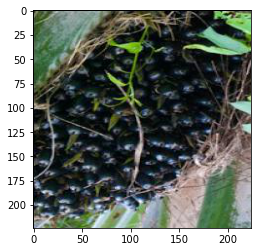

In [13]:
test_img = "C:\\Users\\ardo\\Documents\\semai\\dataset\\ripeness\\ripeness_v8.0\\belum matang\\03-ripe-palm-fruit_jpg.rf.314c95bd801b8d945ce32841398b289f.jpg"

img = tf.keras.preprocessing.image.load_img(
    test_img, target_size=(IMAGE_SIZE, IMAGE_SIZE)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array /= 255
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = np.round(predictions, 4)
class_names = labels.split('\n')

print(score)
print(class_names)

plt.imshow(img)

In [29]:
# Get images and labels batch from validation dataset generator
val_image_batch, val_label_batch = next(iter(val_generator))
print("Validation batch shape:", val_image_batch.shape)

# Get predictions for images batch
tf_model_predictions = model.predict(val_image_batch)

score = np.round(tf_model_predictions, 4)
# >> Prediction results shape: (32, 5)



# Convert prediction results to Pandas dataframe, for better visualization
tf_pred_dataframe = pd.DataFrame(score)
tf_pred_dataframe.columns = class_names

tf_pred_dataframe.head()


Validation batch shape: (32, 224, 224, 3)


,belum matang,jankos,lewat matang,matang
0,0.0011,0.0000,0.1434,0.8554
1,0.7280,0.0021,0.0257,0.2442
2,0.9774,0.0011,0.0091,0.0124
3,0.0012,0.0000,0.0106,0.9882
4,0.9971,0.0005,0.0009,0.0015


In [30]:
timename = time.strftime("%Y%m%d%H%M%S")
tflite_path = "ripeness-" + timename + ".tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_path, 'wb') as f:
  f.write(tflite_model)

In [31]:
timename = time.strftime("%Y%m%d%H%M%S")
tflite_q_path = "ripeness-q-" + timename + ".tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_q_model = converter.convert()
with open(tflite_q_path, 'wb') as f:
  f.write(tflite_q_model)

In [32]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [33]:
# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "ArdNetV1"
model_meta.description = ("ripeness model of SeMAI")
model_meta.version = "v1"
model_meta.author = "Bardo Wenang"
model_meta.license = ("SeMAI License")

# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(224, 224))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [34]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 4 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [100.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("labels_ripe.txt")
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [35]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [36]:
populator = _metadata.MetadataPopulator.with_model_file(tflite_path)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["labels_ripe.txt"])
populator.populate()